opencv_test01完成了基本组件的选择工作，目前基本流程为：
1. Canny边缘提取，膨胀打通连通域，腐蚀确定ROI
2. 切除ROI，在ROI中确定新的边缘

In [1]:
import cv2
import numpy as np
import deal_border as db
src = cv2.imread('../../data/IMG_20181113_113640.jpg')
blurred = cv2.GaussianBlur(src,(3,3),0)
gray=cv2.cvtColor(blurred,cv2.COLOR_RGB2GRAY)
edge_output=cv2.Canny(gray,50,100)
h,w = edge_output.shape
kernel1 = np.ones((4,4),np.uint8)
kernel2 = np.ones((8,8),np.uint8)
dilation = cv2.dilate(edge_output,kernel1,iterations=1)
erosion1 = cv2.erode(dilation,kernel2,iterations=1)
cv2.imshow('src',src)
cv2.imshow('dilation',dilation)
cv2.imshow('erosion',erosion1)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [2]:
y1,y2 = db.getROI_y(erosion1)
y1,y2

([40, 79, 121, 153, 164, 233, 270, 298, 304, 934, 945, 964, 1006, 1124],
 [42, 82, 125, 154, 165, 235, 291, 300, 933, 939, 946, 995, 1008, 1125])

In [3]:
def DelSamllROI(x1,x2,threshold = 5):
    y1 = []
    y2 = []
    for i in range(len(x2)):
        if x2[i] - x1[i] > threshold:
            y1.append(x1[i])
            y2.append(x2[i])
    return y1,y2
    
def findMaxROI(x1,x2):
    max_temp=0
    index = -1
    for i in range(len(x2)):
        if x2[i]-x1[i] > max_temp:
            max_temp = x2[i] - x1[i]
            index = i
    return index
    
y1,y2 = DelSamllROI(y1,y2)
index = findMaxROI(y1,y2)
index,y1,y2

(1, [270, 304, 964], [291, 933, 995])

In [4]:
srctemp = src[y1[index]:y2[index],:,:]
cv2.imshow('srctemp',srctemp)
cv2.waitKey(0)
cv2.destroyAllWindows()

### 以上，假设照片中只有一个图书主体，针对该主体设计特征提取方案

In [5]:
from matplotlib import pyplot as plt
n_segimg = erosion1[y1[index]:y2[index]]
cv2.imshow('srctemp',n_segimg)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
temp1,temp2 = db.getROI_x(n_segimg)
l1,l2 = temp1[0],temp2[-1]
l1,l2

(86, 1731)

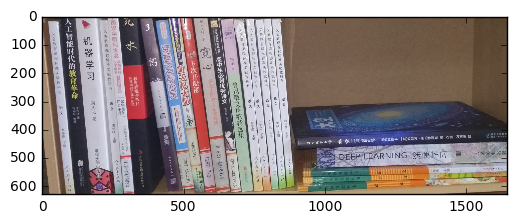

In [7]:
from matplotlib import pyplot as plt
reslut = src[y1[index]:y2[index],l1:l2]
ed_reslut = edge_output[y1[index]:y2[index],l1:l2]
ed_gray = gray[y1[index]:y2[index],l1:l2]
b,g,r= cv2.split(reslut)  
reslut2 = cv2.merge([r,g,b])
cv2.imshow('ed_reslut',ed_reslut)
plt.imshow(reslut2)
plt.show()
cv2.imshow('ed_gray',ed_gray)
cv2.imshow('reslut',reslut)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [40]:
cv2.imwrite('reslut.jpg',reslut)

True

### 小结：
简单来说，不考虑多个框架的情况下，目前可以完成图书区域的分割，进一步研究具体图书的分割

遗留问题是：如何在复杂的场景下提取图书区域，有什么样的算法可供使用，目前虽然通过调节参数完成分割，但是并不具有通用性~

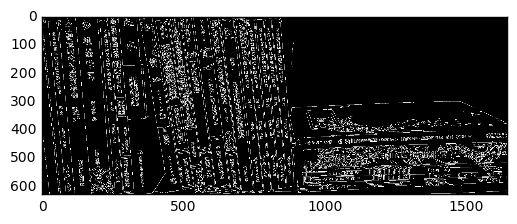

In [8]:
ed_canny=cv2.Canny(ed_gray,30,90)
plt.imshow(ed_canny,cmap='gray')
plt.show()

### 思路
用新的，更细致的canny算法将可能的边缘画出来，用x=n的直线批评，设置匹配门限，取连续门限的中间值

In [28]:
h,w = ed_canny.shape
count = 0
PotList = []
for i in range(w):
    for j in range(h):
        if ed_canny[j,i] > 0:
            count += 1
        else:
            count = 0
        if count > 30:
            PotList.append(i)
            break

In [35]:
PotList[:10]

[1, 100, 102, 105, 107, 141, 142, 143, 144, 145]

In [15]:
h,w=ed_canny.shape
lines = cv2.HoughLines(ed_canny,1,np.pi/180,int(h*0.6))
lines.shape

(347, 1, 2)

In [16]:
lines[0:5]

array([[[307.       ,   0.       ]],

       [[363.       ,   0.       ]],

       [[309.       ,   0.       ]],

       [[ 22.       ,   1.5707964]],

       [[ 30.       ,   1.5707964]]], dtype=float32)

In [17]:
np.pi

3.141592653589793

In [19]:
1.5707964/(np.pi/180)

90.00000419434348

### 可以通过返回值确定线的角度，选择接近90度的，左右各15度吧

15度 = 15*np.pi/180

In [17]:
mintheta,maxtheta = [np.float32(75*np.pi/180),np.float32(105*np.pi/180)]

In [25]:
lines[1,0].shape

(2,)

In [18]:
newlines=[]
for line in lines:
    if line[0,1] < maxtheta and line[0,1] > mintheta:
        newlines.append([line[0,0],line[0,1]])
len(newlines)

298

##### 上述，一定要记得把float32转换成numpy.float32

In [21]:
newlines[0:15]

[[22.0, 1.5707964],
 [30.0, 1.5707964],
 [10.0, 1.6057029],
 [43.0, 1.5358897],
 [15.0, 1.6231562],
 [46.0, 1.5358897],
 [52.0, 1.5009831],
 [44.0, 1.5184364],
 [16.0, 1.6057029],
 [20.0, 1.6057029],
 [15.0, 1.5707964],
 [6.0, 1.6406095],
 [161.0, 1.43117],
 [10.0, 1.6406095],
 [74.0, 1.4835298]]

用hough变换太被动了，浪费效率又浪费时间，自己写一个算法，仿照hough变换，但重点考察连续线性点的个数

In [26]:
h,w = ed_canny.shape
temp_h = 28
x_set=[]
for i in range(w):
    if ed_canny[temp_h,i] > 0:
        cnt = 0
        for j in range(h):
            if temp_h - j > 0 and temp_h + j < h:
                if ed_canny[temp_h - j,i] > 0 or ed_canny[temp_h + j,i] > 0:
                    cnt+=1
                else:
                    break
        if cnt > h//20:
            x_set.append(i)
len(x_set)    

26

好，很好，已经比较接近结果了，下一步，聚类！！

In [31]:
nx_set=[]
for i in range(len(x_set) - 1):
    if x_set[i+1] - x_set[i] < 10:
        nx_set.pop()
        nx_set.append((x_set[i+1] + x_set[i])//2)
        i+=1
    else:
        nx_set.append(x_set[i])

In [32]:
len(nx_set)

18

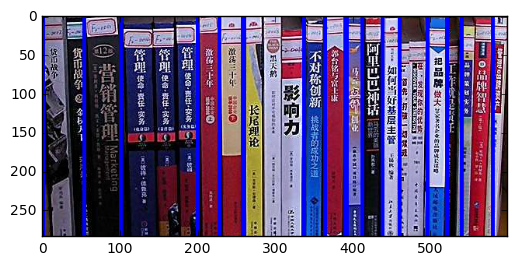

In [35]:
for i in range(len(nx_set)):
    cv2.line(reslut2,(nx_set[i],0),(nx_set[i],h-1),(0,0,255),3)
plt.imshow(reslut2)
plt.show()